# Data Augmentation

## Download the pre-trained model

In [1]:
# Import the necessary package
from tensorflow.keras.applications import MobileNetV2

In [2]:
# Import the desired pre-trained model
# List of pre-trained models: https://www.tensorflow.org/api_docs/python/tf/keras/applications
pre_trained_model = MobileNetV2(include_top=False, pooling='avg')

In [3]:
# Freeze the model so we don't accidentally change the pre-trained model
pre_trained_model.trainable = False

## Load the Oxford Flowers downloaded dataset into Python

In [4]:
# Import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os

In [5]:
# Data from Train folder
train_data_location = os.path.join('..', 'data', 'oxford102', 'train')
train_data = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                horizontal_flip=True,  
                                brightness_range=[0.5, 1.5]).flow_from_directory(train_data_location, 
                                                                               target_size=(224,224))

# Data from Validation folder
validation_data_location = os.path.join('..', 'data', 'oxford102', 'validation')
validation_data = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(validation_data_location, 
                                                                                                  target_size=(224,224))

Found 1021 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.


In [6]:
# Check the output mappings
class_mappings = train_data.class_indices
print(f'The mappings are {class_mappings}')

The mappings are {'alpine sea holly': 0, 'anthurium': 1, 'artichoke': 2, 'azalea': 3, 'ball moss': 4, 'balloon flower': 5, 'barbeton daisy': 6, 'bearded iris': 7, 'bee balm': 8, 'bird of paradise': 9, 'bishop of llandaff': 10, 'black-eyed susan': 11, 'blackberry lily': 12, 'blanket flower': 13, 'bolero deep blue': 14, 'bougainvillea': 15, 'bromelia': 16, 'buttercup': 17, 'californian poppy': 18, 'camellia': 19, 'canna lily': 20, 'canterbury bells': 21, 'cape flower': 22, 'carnation': 23, 'cautleya spicata': 24, 'clematis': 25, 'colts foot': 26, 'columbine': 27, 'common dandelion': 28, 'corn poppy': 29, 'cyclamen': 30, 'daffodil': 31, 'desert-rose': 32, 'english marigold': 33, 'fire lily': 34, 'foxglove': 35, 'frangipani': 36, 'fritillary': 37, 'garden phlox': 38, 'gaura': 39, 'gazania': 40, 'geranium': 41, 'giant white arum lily': 42, 'globe thistle': 43, 'globe-flower': 44, 'grape hyacinth': 45, 'great masterwort': 46, 'hard-leaved pocket orchid': 47, 'hibiscus': 48, 'hippeastrum': 49

## Training the model on your dataset

In [7]:
# Import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense

In [8]:
# To create a model for our needs, first create a blank model
model = Sequential()

# Then add the pre-trained model to use Transfer Learning
model.add(pre_trained_model)

# Finally add our custom modifications
model.add(Dropout(0.5))
model.add(Dense(len(class_mappings), activation='softmax'))

# Make the model ready for training
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model for 10 epochs
training_history_es = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
32/32 [==============================] - 7s 207ms/step - loss: 4.8687 - accuracy: 0.0411 - val_loss: 3.3491 - val_accuracy: 0.2971
Epoch 2/5
32/32 [==============================] - 5s 159ms/step - loss: 3.0869 - accuracy: 0.2693 - val_loss: 2.4040 - val_accuracy: 0.5510
Epoch 3/5
32/32 [==============================] - 5s 160ms/step - loss: 2.0994 - accuracy: 0.5162 - val_loss: 1.8615 - val_accuracy: 0.6569
Epoch 4/5
32/32 [==============================] - 5s 163ms/step - loss: 1.5073 - accuracy: 0.6719 - val_loss: 1.5152 - val_accuracy: 0.6990
Epoch 5/5
32/32 [==============================] - 5s 158ms/step - loss: 1.1688 - accuracy: 0.7336 - val_loss: 1.3123 - val_accuracy: 0.7314


### Plot the training losses

In [10]:
# Import the necessary package
import matplotlib.pyplot as plt

# Custom function
def plot_training_loss(training_history):
    # Plot the Training and Validation losses over each epoch
    plt.plot(training_history.history['loss'], label='training loss')
    plt.plot(training_history.history['val_loss'], label='validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
# Custom function
def plot_training_accuracy(training_history):
    # Plot the Training and Validation losses over each epoch
    plt.plot(training_history.history['accuracy'], label='training accuracy')
    plt.plot(training_history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

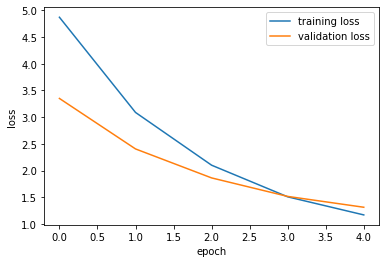

In [11]:
plot_training_loss(training_history_es)

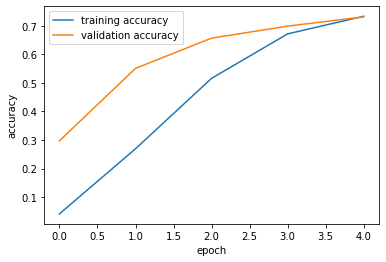

In [12]:
plot_training_accuracy(training_history_es)

In [13]:
# Save the trained model to a file for future use
model.save(os.path.join('..', 'models', 'oxford_flowers_checkpoint1.h5'))

## Fine-Tuning by Un-freezing last few layers in pre-trianed model

In [14]:
# Let's take a look to see how many layers are in ResNet50
print('Number of layers in Mobile Net V2: ', len(pre_trained_model.layers))

Number of layers in Mobile Net V2:  156


In [15]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
# Unfreeze last N layers
n_unfreeze = 4
for layer in pre_trained_model.layers[-n_unfreeze:]:
    layer.trainable = True

In [17]:
# Train the model for 10 epochs
training_history_es = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
32/32 [==============================] - 5s 163ms/step - loss: 0.9235 - accuracy: 0.8012 - val_loss: 1.1701 - val_accuracy: 0.7441
Epoch 2/5
32/32 [==============================] - 5s 156ms/step - loss: 0.7354 - accuracy: 0.8276 - val_loss: 1.0784 - val_accuracy: 0.7647
Epoch 3/5
32/32 [==============================] - 5s 157ms/step - loss: 0.5824 - accuracy: 0.8727 - val_loss: 1.0033 - val_accuracy: 0.7706
Epoch 4/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4813 - accuracy: 0.8942 - val_loss: 0.9506 - val_accuracy: 0.7676
Epoch 5/5
32/32 [==============================] - 5s 166ms/step - loss: 0.4399 - accuracy: 0.8991 - val_loss: 0.9080 - val_accuracy: 0.7755


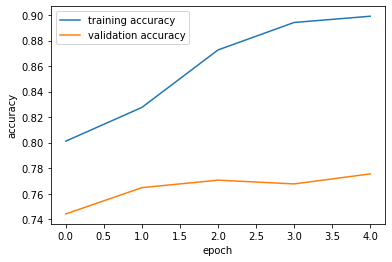

In [19]:
plot_training_accuracy(training_history_es)

In [20]:
# Save the trained model to a file for future use
model.save(os.path.join('..', 'models', 'oxford_flowers_checkpoint2.h5'))

In [21]:
# Unfreeze some more last N layers
n_unfreeze = 12
for layer in pre_trained_model.layers[-n_unfreeze:]:
    layer.trainable = True

In [22]:
# Train the model for 10 epochs
training_history_es = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
32/32 [==============================] - 5s 162ms/step - loss: 0.3748 - accuracy: 0.9246 - val_loss: 0.8774 - val_accuracy: 0.7716
Epoch 2/5
32/32 [==============================] - 5s 166ms/step - loss: 0.3151 - accuracy: 0.9363 - val_loss: 0.8511 - val_accuracy: 0.7784
Epoch 3/5
32/32 [==============================] - 5s 159ms/step - loss: 0.2919 - accuracy: 0.9383 - val_loss: 0.8283 - val_accuracy: 0.7765
Epoch 4/5
32/32 [==============================] - 5s 158ms/step - loss: 0.2515 - accuracy: 0.9461 - val_loss: 0.8180 - val_accuracy: 0.7882
Epoch 5/5
32/32 [==============================] - 5s 161ms/step - loss: 0.2050 - accuracy: 0.9657 - val_loss: 0.8007 - val_accuracy: 0.7814


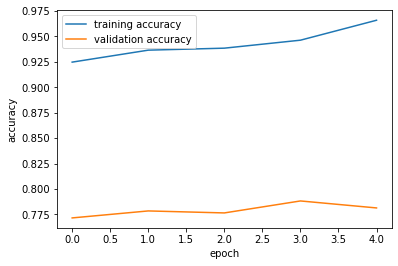

In [23]:
plot_training_accuracy(training_history_es)

In [24]:
# Save the trained model to a file for future use
model.save(os.path.join('..', 'models', 'oxford_flowers_checkpoint3.h5'))

In [25]:
# Unfreeze some more last N layers
n_unfreeze = 21
for layer in pre_trained_model.layers[-n_unfreeze:]:
    layer.trainable = True

In [26]:
# Train the model for 10 epochs
training_history_es = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
32/32 [==============================] - 5s 160ms/step - loss: 0.1893 - accuracy: 0.9638 - val_loss: 0.7880 - val_accuracy: 0.7853
Epoch 2/5
32/32 [==============================] - 5s 167ms/step - loss: 0.1819 - accuracy: 0.9618 - val_loss: 0.7582 - val_accuracy: 0.7961
Epoch 3/5
32/32 [==============================] - 5s 159ms/step - loss: 0.1381 - accuracy: 0.9726 - val_loss: 0.7626 - val_accuracy: 0.7980
Epoch 4/5
32/32 [==============================] - 5s 168ms/step - loss: 0.1370 - accuracy: 0.9677 - val_loss: 0.7702 - val_accuracy: 0.7853
Epoch 5/5
32/32 [==============================] - 5s 170ms/step - loss: 0.1281 - accuracy: 0.9755 - val_loss: 0.7558 - val_accuracy: 0.8000


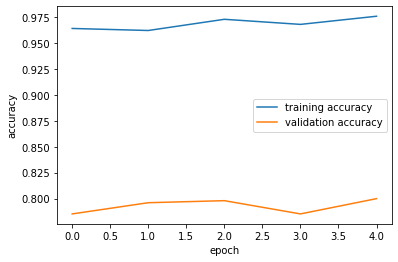

In [27]:
plot_training_accuracy(training_history_es)

In [28]:
# Save the trained model to a file for future use
model.save(os.path.join('..', 'models', 'oxford_flowers_final_model.h5'))

## Conclusion
- The final model after data augmentation and model fine tuning gives a validation accuracy of ~80%
- The flow I use to training models is 
    1. Train on just the pre_trained_model first and check the training plots
    2. Add Regularization if there is overfitting and train again
    3. Inspect some of the errors and form a hypothesis of how the model is performing
    4. Perform data augmentation on the training dataset to help the model go in the right direction
    5. Fine tune some of the last few layers of the pre_trained_model
    6. At every step save a copy of the model as a checkpoint